In [1]:
import pyspark as ps
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import col
from pyspark.sql.functions import countDistinct

spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("nathanscope") 
        .getOrCreate()
        )

In [2]:
sc = spark.sparkContext

In [3]:
# import the many data types
from pyspark.sql.types import *

# create a schema of your own
auth_schema = StructType( [
    StructField('time',     LongType(), True),
    StructField('src_user_domain',   StringType(),  True),
    StructField('dst_user_domain',   StringType(),  True),
    StructField('src_comp',   StringType(),  True),
    StructField('dst_comp',   StringType(),  True),
    StructField('auth_type',  StringType(), True),
    StructField('logon_type',  StringType(),  True),
    StructField('auth_orientation',  StringType(),  True),
    StructField('Success',  StringType(),  True)] )

proc_schema = StructType( [
    StructField('time',     LongType(), True),
    StructField('user_domain',   StringType(),  True),
    StructField('comp',   StringType(),  True),
    StructField('proc_name',   StringType(),  True),
    StructField('start',   StringType(),  True),
    ] )

flow_schema = StructType( [
    StructField('time',     LongType(), True),
    StructField('duration',     LongType(), True),
    StructField('src_comp',   StringType(),  True),
    StructField('src_port',   StringType(),  True),
    StructField('dst_comp',   StringType(),  True),
    StructField('dst_port',   StringType(),  True),
    StructField('protocol',  StringType(), True),
    StructField('pk_count',  LongType(),  True),
    StructField('byte_count',  LongType(),  True)] )

DNS_schema = StructType( [
    StructField('time',     LongType(), True),
    StructField('src_comp',   StringType(),  True),
    StructField('comp_resolved',   StringType(),  True),
    
    ] )


In [4]:
rdd_auth = (sc.pickleFile("Data/Day1/auth/part*")
            
           )

rdd_proc = (sc.pickleFile("Data/Day1/proc/part*")
            
           )

rdd_flow = (sc.pickleFile('Data/Day1/flow/part*')
           )

rdd_DNS = (sc.pickleFile("Data/Day1/DNS/part*")
           
           )

In [5]:
auth_df = spark.createDataFrame(rdd_auth,auth_schema)

proc_df = spark.createDataFrame(rdd_proc,proc_schema)

flow_df = spark.createDataFrame(rdd_flow,flow_schema)

DNS_df = spark.createDataFrame(rdd_DNS,DNS_schema)

In [6]:
add_success_value = udf(lambda x : 1 if x == 'Success' else 0 )

In [7]:
auth_df = auth_df.withColumn('Success_Value', add_success_value(auth_df['Success']))

In [8]:
## View Logon Types
logon_df = auth_df.groupBy('logon_type').agg({'Success_Value': 'mean','Success':'count'}).collect()

In [9]:
logon_df = pd.DataFrame(logon_df)
logon_df.columns = ['logon_type','avg_success','count_success']

In [10]:
logon_df

,logon_type,avg_success,count_success
0,RemoteInteractive,0.944963,3216
1,NewCredentials,0.980679,7453
2,Interactive,0.961738,57106
3,CachedInteractive,0.889208,4522
4,NetworkCleartext,0.995702,7678
5,Network,0.997269,12833548
6,Batch,0.924853,30926
7,?,0.973291,2489344
8,Service,0.999707,228900
9,Unlock,0.964649,78075


# Investigate unique users counts by logon type

In [11]:
interactive_src_df = auth_df.filter("logon_type = 'Interactive'").groupBy('src_user_domain').agg({'Success_Value': 'mean','Success':'count'}).collect()
interactive_dst_df = auth_df.filter("logon_type = 'Interactive'").groupBy('dst_user_domain').agg({'Success_Value': 'mean','Success':'count'}).collect()

In [12]:
interactive_src_df = pd.DataFrame(interactive_src_df)

In [13]:
interactive_src_df.columns = ['user','avg_success','count_success']

In [14]:
interactive_src_df = interactive_src_df.sort_values('count_success',ascending=False)

In [15]:
interactive_dst_df = pd.DataFrame(interactive_dst_df)
interactive_dst_df.columns = ['user','avg_success','count_success']
interactive_dst_df = interactive_dst_df.sort_values('count_success',ascending=False)

In [16]:
len(interactive_dst_df)

5055

In [17]:
len(interactive_src_df)

5523

In [18]:
interactive_dst_DOM_df = interactive_dst_df[[('DOM' in x) for x in interactive_dst_df['user']]]
interactive_src_DOM_df = interactive_src_df[[('DOM' in x) for x in interactive_src_df['user']]]

(array([5.518e+03, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([1.00000e+00, 1.76750e+03, 3.53400e+03, 5.30050e+03, 7.06700e+03,
        8.83350e+03, 1.06000e+04, 1.23665e+04, 1.41330e+04, 1.58995e+04,
        1.76660e+04]),
 <a list of 10 Patch objects>)

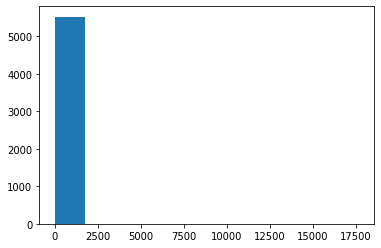

In [19]:
plt.hist(interactive_src_df['count_success'])

In [20]:
len(interactive_src_DOM_df)

5387

In [21]:
len(interactive_src_df)

5523

In [22]:
len(interactive_dst_DOM_df)

4817

In [23]:
len(interactive_dst_df)

5055

In [24]:
src_df = auth_df.groupBy('src_user_domain').agg({'Success_Value': 'mean','Success':'count'}).collect()
dst_df = auth_df.groupBy('dst_user_domain').agg({'Success_Value': 'mean','Success':'count'}).collect()

dst_df = pd.DataFrame(dst_df)
dst_df.columns = ['user','avg_success','count_success']
dst_df = dst_df.sort_values('count_success',ascending=False)


src_df = pd.DataFrame(interactive_dst_df)
src_df.columns = ['user','avg_success','count_success']
src_df = src_df.sort_values('count_success',ascending=False)

src_DOM_df = src_df[[('DOM' in x and '$' not in x) for x in src_df['user']]]
dst_DOM_df = dst_df[[('DOM' in x and '$' not in x) for x in dst_df['user']]]



In [25]:
len(src_df)

5055

In [26]:
len(dst_df)

42837

In [27]:
len(src_DOM_df)

4811

In [28]:
len(dst_DOM_df)

8202

In [29]:
active_users = list(src_DOM_df['user'])

In [30]:
active_auth_df = auth_df.where(col("src_user_domain").isin(active_users))

In [31]:
active = active_auth_df.groupBy('src_user_domain').agg(countDistinct("src_comp")).collect()



In [32]:
active_auth_df.agg(countDistinct("src_comp")).collect()

[Row(count(DISTINCT src_comp)=5971)]

In [33]:
pd_active = pd.DataFrame(active)

In [34]:
active_auth_df.count()

2893572

In [39]:
active

[Row(src_user_domain='U4272@DOM1', count(DISTINCT src_comp)=6),
 Row(src_user_domain='U150@DOM1', count(DISTINCT src_comp)=19),
 Row(src_user_domain='U6613@DOM1', count(DISTINCT src_comp)=8),
 Row(src_user_domain='U5608@DOM1', count(DISTINCT src_comp)=7),
 Row(src_user_domain='U7087@DOM1', count(DISTINCT src_comp)=7),
 Row(src_user_domain='U6347@DOM1', count(DISTINCT src_comp)=9),
 Row(src_user_domain='U3147@DOM1', count(DISTINCT src_comp)=13),
 Row(src_user_domain='U1490@DOM1', count(DISTINCT src_comp)=11),
 Row(src_user_domain='U4392@DOM1', count(DISTINCT src_comp)=12),
 Row(src_user_domain='U3283@DOM1', count(DISTINCT src_comp)=10),
 Row(src_user_domain='U4475@DOM1', count(DISTINCT src_comp)=9),
 Row(src_user_domain='U3539@DOM1', count(DISTINCT src_comp)=11),
 Row(src_user_domain='U3297@DOM1', count(DISTINCT src_comp)=11),
 Row(src_user_domain='U3170@DOM1', count(DISTINCT src_comp)=12),
 Row(src_user_domain='U2701@DOM1', count(DISTINCT src_comp)=15),
 Row(src_user_domain='U1336@DOM1

In [ ]:
len(pd_active_auth_df)

In [ ]:
pd_active_auth_df.head()

In [ ]:
active_comps = list(set(list(pd_active_auth_df[3])))

In [ ]:
len(active_comps)

In [ ]:
# here we discovered a way to filter our data to look at only user traffic and that most users seem to map evenly to a computer

In [ ]:
active_flow_df = flow_df.where(col("src_user_domain").isin(active_users))